# Analyis NLP

In this notebook, the script lines of the TV-show are analyzed using both traditional methods (such as ngrams, TF-IDF, ...) and modern approaches (i.e. transformers).

In [77]:
# TODO: suppress warnings - i get no warnings on my machine, no idea what you mean
import os
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from matplotlib import pyplot as plt
from yellowbrick.text import DispersionPlot
from wordcloud import WordCloud
import torch

import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

import networkx as nx

from transformers import AutoTokenizer, AutoModelForSequenceClassification

from preprocessing_nlp import preprocess, extract_features

PATH = "../data/"
FILE = "the-office-lines_scripts.csv"

In [2]:
df_raw = pd.read_csv(PATH+FILE, sep=",", index_col="id")
df_raw.head()

,season,episode,scene,line_text,speaker,deleted
id,,,,,,
1,1,1,1,All right Jim. Your quarterlies look very good...,Michael,False
2,1,1,1,"Oh, I told you. I couldn't close it. So...",Jim,False
3,1,1,1,So you've come to the master for guidance? Is ...,Michael,False
4,1,1,1,"Actually, you called me in here, but yeah.",Jim,False
5,1,1,1,"All right. Well, let me show you how it's done.",Michael,False


Short preprocessing: Extract directionals (and remove deleted scenes + respective column):

In [3]:
param_dict = {
    "concat_scenes": False,
    "extract_direc": True, 
    "remove_punct": False, 
    "rmv_stopwords": False,
    "lwr": False, 
    "exp_contractions": False,
    "conversion": None
}

df = preprocess(df_raw, **param_dict)
df.head()

,season,episode,scene,line_text,speaker,season_episode,directionals
id,,,,,,,
1,1,1,1,All right Jim. Your quarterlies look very good...,Michael,101,NaN
2,1,1,1,"Oh, I told you. I couldn't close it. So...",Jim,101,NaN
3,1,1,1,So you've come to the master for guidance? Is ...,Michael,101,NaN
4,1,1,1,"Actually, you called me in here, but yeah.",Jim,101,NaN
5,1,1,1,"All right. Well, let me show you how it's done.",Michael,101,NaN


### Frequency Analysis
Extract knowledge from the dataset based on frequency analysis of appearances, lines and words per character. 
Plotting the frequency over time reveals key moments in the show and highlights important characters.

In [4]:
char_app = df.sort_values(['season','episode','scene']).drop_duplicates(['season','episode','scene','speaker'],keep='first')
char_app_count = char_app.groupby(['speaker', 'season']).size().reset_index(name='counts')

char_app_count['season'] = char_app_count['season'].astype(str)

top_char = char_app.groupby(['speaker']).size().reset_index(name='counts').sort_values(by='counts', ascending=False)['speaker'].iloc[:20]

#filter for top 20 characters
char_app_count_sorted = char_app_count[char_app_count['speaker'].isin(top_char)].sort_values(by=['season'])

fig = px.bar(char_app_count_sorted, x='speaker', y='counts', color='season', color_discrete_sequence=px.colors.qualitative.Prism, title='Scene appearances per character')
fig.update_xaxes(categoryorder='array', categoryarray= top_char)


In [5]:
top20_characters = df["speaker"].value_counts().head(20).index.tolist()
lines_per_character = df[["speaker", "season", "line_text"]][df["speaker"].isin(top20_characters)].groupby(["speaker", "season"]).count().reset_index(level=[0,1])
lines_per_character['season'] = lines_per_character['season'].astype(str)
fig = px.bar(lines_per_character.sort_values("season"), x="speaker", y="line_text", color='season', color_discrete_sequence=px.colors.qualitative.Prism, title='Lines per character')
fig.update_xaxes(categoryorder='array', categoryarray= top20_characters)
fig.update_yaxes(title='number of lines')

In [6]:
words_df = df.copy()
words_df['word_count'] = words_df['line_text'].apply(lambda x: len(x.split()))
top20_characters = words_df[["speaker", "word_count"]].groupby("speaker").sum().sort_values("word_count", ascending=False).index[:20]
words_per_character = words_df[["speaker", "season", "word_count"]][words_df["speaker"].isin(top20_characters)].groupby(["speaker", "season"]).sum().reset_index(level=[0,1])
words_per_character['season'] = words_per_character['season'].astype(str)

fig = px.bar(words_per_character.sort_values("season"), x="speaker", y="word_count", color='season', color_discrete_sequence=px.colors.qualitative.Prism, title='Words per character')
fig.update_xaxes(categoryorder='array', categoryarray= top20_characters)
fig.update_yaxes(title='number of words')

- Michael is overall the most frequent appearing character
- Dwight, Jim, Pam and Andy are other frequently appearing (and thus important) characters
- the order of the supporting characters differs depending on what is counted (scene appearances, lines, words)
- some characters only appear in specific seasons (e.g. Michael 1-7 or Robert 8)

In [7]:
speaker_list = ["Michael", "Dwight", "Jim", "Pam", "Andy"]

lines_per_speaker_episode = df.loc[df["speaker"].isin(speaker_list)].groupby(["speaker", "season_episode"]).count()["line_text"].unstack(fill_value=0).stack().reset_index(level=['speaker', 'season_episode']).sort_values("season_episode")
lines_per_speaker_episode.sort_values(["season_episode"], inplace=True)
lines_per_speaker_episode.rename(columns={0: "number of lines"}, inplace=True)

fig = px.line(lines_per_speaker_episode, x="season_episode", y="number of lines", color="speaker", title="Lines per speaker and episode")

fig.add_annotation(
    x=17
    , y=170
    , text=f'Andy is introduced'
    , showarrow=False
    , align="left")

fig.add_annotation(
    x=87.5
    , y=170
    , text=f'Birth of Jim and Pam\'s daughter'
    , showarrow=False
    , align="left")

fig.add_annotation(
    x=126.5
    , y=170
    , text=f'Michael leaves'
    , showarrow=False
    , align="left")

fig.update_layout(shapes=
                  [dict(type= 'line',
                        yref= 'paper', y0= 0, y1= 1,
                        xref= 'x', x0=28, x1=28,
                        line=dict(color="Black",
                                  width=1,
                                  dash="dot")
                        ),
                    dict(type= 'line',
                        yref= 'paper', y0= 0, y1= 1,
                        xref= 'x', x0=106, x1=106,
                        line=dict(color="Black",
                                  width=1,
                                  dash="dot")
                        ),
                    dict(type= 'line',
                        yref= 'paper', y0= 0, y1= 1,
                        xref= 'x', x0=135, x1=135,
                        line=dict(color="Black",
                                  width=1,
                                  dash="dot")
                        ),
                  ]                
                  )

fig.add_vrect(x0="170", x1="176", 
              annotation_text="Andy is on a boat trip", annotation_position="top right",  
              annotation_font_size=11,
              annotation_font_color="Blue",
              fillcolor="blue", opacity=0.25, line_width=0)

- certain events in the show can be identified by plotting the number of lines per speaker over time (only some are displayed, even more may be identified by fans of the show)
- Michael clearly dominates in terms of speech portions and is "replaced" jointly by Dwight, Jim, Pam and especially Andy

### Content Analysis
Extracting important words from lines to determine key topics and speaking styles in the show.

Preprocessing: Extract directorials, remove punctuation, lowercase, expand contractions, tokenize lines using TreeBankWord and special tokens (names and compound words)

In [8]:
param_dict_tokens = {
    "concat_scenes": False,
    "extract_direc": True, 
    "remove_punct": True, 
    "rmv_stopwords": False,
    "lwr": True, 
    "exp_contractions": True,
    "conversion": "tokenize",
    "tokenizer": ("TreeBankWord", True, PATH+"character_names.csv", PATH+"compound_words_the-office_by_chatgpt.txt")
}

df_tokens = preprocess(df_raw, **param_dict_tokens)
df_tokens.head()

,season,episode,scene,line_text,speaker,season_episode,directionals
id,,,,,,,
1,1,1,1,"[all, right, jim, your, quarterlies, look, ver...",Michael,101,NaN
2,1,1,1,"[oh, i, told, you, i, could, not, close, it, so]",Jim,101,NaN
3,1,1,1,"[so, you, have, come, to, the, master, for, gu...",Michael,101,NaN
4,1,1,1,"[actually, you, called, me, in, here, but, yeah]",Jim,101,NaN
5,1,1,1,"[all, right, well, let, me, show, you, how, it...",Michael,101,NaN


#### Word Cloud

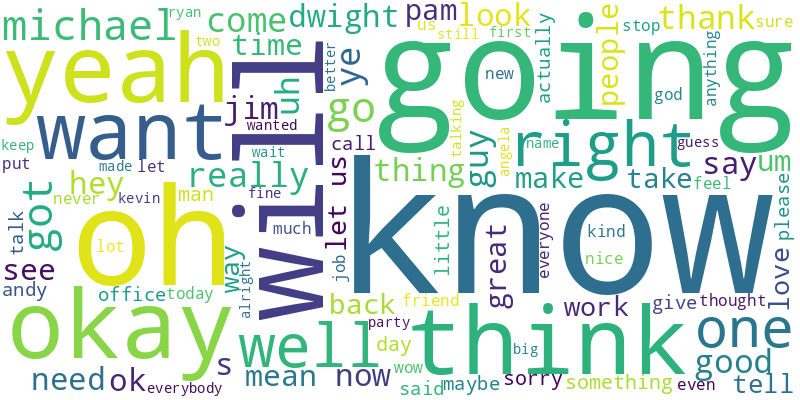

In [9]:
all_words =  [item for sublist in df_tokens["line_text"].tolist() for item in sublist]
all_words_freq = nltk.FreqDist(all_words)
df_all_words_freq = pd.Series(dict(all_words_freq)).sort_values(ascending=False)

wordcloud = WordCloud(width=800, height=400, background_color="white", max_words=100, contour_width=3, contour_color='steelblue').generate(" ".join(all_words))
wordcloud.to_image()


- mostly words that are common in everyday language use
- also some names of characters
- topic related words are rare (e.g. job, office, work, call, party, friend, love)

In [10]:
fig = px.bar(y=df_all_words_freq[:16].index, x=df_all_words_freq[:16].values, orientation='h', title='Most common words')
fig.update_layout(yaxis_title='Word', xaxis_title='Frequency')

fig.show()


- same conclusion as above: words that are frequently used in general, no nouns

New preprocessing: additionally remove stopwords

In [11]:
param_dict_tokens_nostopwords = {
    "concat_scenes": False,
    "extract_direc": True, 
    "remove_punct": True, 
    "rmv_stopwords": True,
    "lwr": True, 
    "exp_contractions": True,
    "conversion": "tokenize",
    "tokenizer": ("TreeBankWord", True, PATH+"character_names.csv", PATH+"compound_words_the-office_by_chatgpt.txt")
}

df_tokens_nostopwords = preprocess(df_raw, **param_dict_tokens_nostopwords)
df_tokens_nostopwords.head()

,season,episode,scene,line_text,speaker,season_episode,directionals
id,,,,,,,
1,1,1,1,"[right, jim, quarterlies, look, good, things, ...",Michael,101,NaN
2,1,1,1,"[oh, told, could, close]",Jim,101,NaN
3,1,1,1,"[come, master, guidance, saying, grasshopper]",Michael,101,NaN
4,1,1,1,"[actually, called, yeah]",Jim,101,NaN
5,1,1,1,"[right, well, let, show, done]",Michael,101,NaN


In [12]:
all_words =  [item for sublist in df_tokens_nostopwords["line_text"].tolist() for item in sublist]
all_words_freq = nltk.FreqDist(all_words)
df_all_words_freq = pd.Series(dict(all_words_freq)).sort_values(ascending=False)

fig2 = px.bar(y=df_all_words_freq[:16].index, x=df_all_words_freq[:16].values, orientation='h', title='Most common words (after stopword removal)')
fig2.show()

### Finding the most important Words
A Brill Tagger was used, but didn't show sufficient results. 

Preprocessing with POS-tagging:

In [11]:
param_dict_tokens_nostopwords = {
    "concat_scenes": False,
    "extract_direc": True, 
    "remove_punct": False, 
    "rmv_stopwords": False,
    "lwr": True, # TODO: CAN WE USE LOWER HERE? SEE E.G. WORD "GOOD"
    "exp_contractions": False,
    "conversion": "pos_tag"
}

df_tokens_tagged = preprocess(df_raw, **param_dict_tokens_nostopwords)
df_tokens_tagged.head()

,season,episode,scene,line_text,speaker,season_episode,directionals
id,,,,,,,
1,1,1,1,"[(all, DT), (right, JJ), (jim., NN), (your, PR...",Michael,101,NaN
2,1,1,1,"[(oh, UH), (,, ,), (i, JJ), (told, VBD), (you....",Jim,101,NaN
3,1,1,1,"[(so, RB), (you, PRP), ('ve, VBP), (come, VBN)...",Michael,101,NaN
4,1,1,1,"[(actually, RB), (,, ,), (you, PRP), (called, ...",Jim,101,NaN
5,1,1,1,"[(all, DT), (right., NN), (well, RB), (,, ,), ...",Michael,101,NaN


In [18]:
# use plotly simple white theme
import plotly.io as pio
pio.templates.default = "plotly_white"


# filter words by POS tag
all_words_tagged =  [item for sublist in df_tokens_tagged["line_text"].tolist() for item in sublist]
all_words_tagged_filtered_jj = [item[0] for item in all_words_tagged if item[1] in ["JJ", "JJR", "JJS"]]
all_words_tagged_filtered_nn = [item[0] for item in all_words_tagged if item[1] in ["NN", "NNS", "NNP", "NNPS"]]

all_tagged_freq = nltk.FreqDist(all_words_tagged_filtered_jj)
df_all_tagged_freq = pd.Series(dict(all_tagged_freq)).sort_values(ascending=False).drop('i')


fig2 = px.bar(y=df_all_tagged_freq[:15].index, x=df_all_tagged_freq[:15].values, orientation='h', title='Most common Adjectives', height=700)
fig2.update_traces(width=0.5)
fig2.show()

all_tagged_freq = nltk.FreqDist(all_words_tagged_filtered_nn)
df_all_tagged_freq = pd.Series(dict(all_tagged_freq)).sort_values(ascending=False)

fig3 = px.bar(y=df_all_tagged_freq[:15].index, x=df_all_tagged_freq[:15].values, orientation='h', title='Most common Nouns', height=700)
fig3.update_traces(width=0.5)
fig3.show()




### TF-IDF to determine important words in the dataset

In [4]:
param_dict_concat_scenes = {
    "concat_scenes": True,
    "extract_direc": True, 
    "remove_punct": False, 
    "rmv_stopwords": False,
    "lwr": True, 
    "exp_contractions": True,
}

df_concat_scenes = preprocess(df_raw, **param_dict_concat_scenes)

Use TF-IDF for feature extraction:

In [22]:
all_words_tagged_filtered = [item[0] for item in all_words_tagged]
features_tfidf_agg = extract_features(df_concat_scenes, "tfidf").mean(axis=0).sort_values(ascending=False)

# filter features_tfidf_agg by all_words_tagged_filtered
features_tfidf_agg = features_tfidf_agg[features_tfidf_agg.index.isin(all_words_tagged_filtered)]

In [23]:
features_tfidf_agg[0:10]

you     0.072911
is      0.056919
to      0.054235
the     0.052029
it      0.047500
that    0.040082
pam     0.039464
not     0.038828
and     0.037477
do      0.032911
dtype: float64

### Lexical Dispersion Plot

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


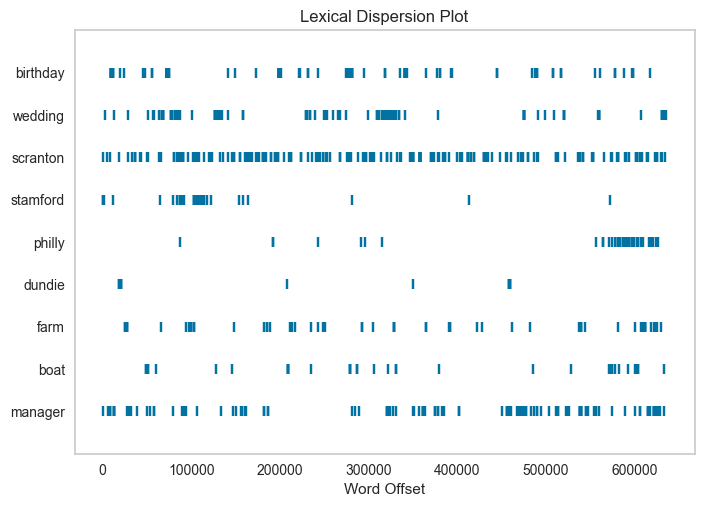

In [24]:
target_words = ['birthday', 'wedding', 'scranton', 'stamford', 'philly', 'dundie', 'farm', 'boat', 'manager']
visualizer = DispersionPlot(target_words)
visualizer.fit([all_words])
visualizer.show();

In [37]:
# TODO: find cool word or remove - i tried several, but there is no one with ambiguous meaning
nltk.Text(all_words).concordance('office', lines=10)

Displaying 10 of 643 matches:
e yes i would like to speak to your office manager please yes hello this is mi
 this regime it will not leave this office like that so what does downsizing a
ee what people are like outside the office i think it could be fun it sounds g
nts you made here is the thing this office i think this is very advanced in te
you pick a health_care_plan for our office and then explain it to your coworke
r the time being two i will need an office i think the conference_room should 
a temporary workspace yes i have an office bigger than his nope you can not us
 tricks where are you oh i am in my office i am swamped i have work up to my e
at uh just do not let anybody in my office under any conditions today i am jus
nock please please knock this is an office it says workspace same thing if it 


In [26]:
#find n-grams
finder_2 = nltk.collocations.BigramCollocationFinder.from_words(all_words)
finder_3 = nltk.collocations.TrigramCollocationFinder.from_words(all_words)
finder_4 = nltk.collocations.QuadgramCollocationFinder.from_words(all_words)

finder_3.ngram_fd.most_common(20)

[(('let', 'us', 'go'), 203),
 (('let', 'us', 'get'), 107),
 (('hey', 'hey', 'hey'), 78),
 (('whoa', 'whoa', 'whoa'), 63),
 (('oh', 'god', 'oh'), 59),
 (('na', 'na', 'na'), 55),
 (('let', 'us', 'see'), 52),
 (('go', 'go', 'go'), 49),
 (('one', 'two', 'three'), 45),
 (('stop', 'stop', 'stop'), 44),
 (('god', 'oh', 'god'), 41),
 (('come', 'let', 'us'), 39),
 (('blah', 'blah', 'blah'), 37),
 (('ha', 'ha', 'ha'), 35),
 (('okay', 'let', 'us'), 34),
 (('yes', 'yes', 'yes'), 33),
 (('wait', 'wait', 'wait'), 32),
 (('get', 'back', 'work'), 31),
 (('yeah', 'yeah', 'yeah'), 28),
 (('oh', 'oh', 'oh'), 28)]

- interesting 3-grams support that everyday spoken language is used in the show (colloquial language/slang)
- few topic related 3-grams: e.g. get back work

## Sentiment Analysis

#### Sentiment over time: negative, neutral, positive

In [49]:
sia = SentimentIntensityAnalyzer()
sia.polarity_scores("All right Jim. Your quarterlies look very good. How are things at the library?")

{'neg': 0.0, 'neu': 0.803, 'pos': 0.197, 'compound': 0.4927}

In [50]:
# calculate sentiment scores for each line
df_unp = preprocess(df_raw)
df_sentiment = df_unp
df_sentiment["sentiment"] = df_sentiment["line_text"].apply(lambda x: sia.polarity_scores(x))

In [51]:
# visualize sentiment scores over time

# set id as column 
df_sentiment['id'] = df_sentiment.index

# set new row as numerical
df_sentiment['neg'] = df_sentiment['sentiment'].apply(lambda x: x['neg'])
df_sentiment['neu'] = df_sentiment['sentiment'].apply(lambda x: x['neu'])
df_sentiment['pos'] = df_sentiment['sentiment'].apply(lambda x: x['pos'])

In [52]:
df_rolling = df_sentiment.rolling(10).mean()

C:\Users\schla\AppData\Local\Temp\ipykernel_4884\2529880343.py:1: FutureWarning:

Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['line_text', 'sentiment', 'speaker'], dtype='object')



In [67]:
# display sentiment over time for a given season and episode
px.line(df_rolling[(df_rolling["season"] == 7) & (df_rolling['episode'] >= 21)], x="id", y=["neg", "neu", "pos"], title="Sentiment over time", color_discrete_sequence=px.colors.qualitative.Pastel)

The below displayed episode is "Goodbye Michael"

In [64]:
# show the first few lines of season 4 episiod 13
df_raw[(df_raw["season"] == 4) & (df_raw['episode'] == 9)].head(10)

,season,episode,scene,line_text,speaker,deleted
id,,,,,,
20468,4,9,1,This is ridiculous.,Stanley,False
20469,4,9,1,Do you have any idea what time we'll get out o...,Phyllis,False
20470,4,9,1,"Nobody likes to work late, least of all me. [t...",Michael,False
20471,4,9,1,"Nope I don't, remember when you told us not to...",Jim,False
20472,4,9,1,"Yes I remember. Mmm, this is B.S. This is B.S....",Michael,False
20473,4,9,1,Thank you Michael.,Dwight,False
20474,4,9,1,"All right, happy Friday. [to Jim] Well I think...",Michael,False
20475,4,9,1,I think you did.,Jim,False
20476,4,9,1,"I think we should celebrate. How about you, Pa...",Michael,False


Additionally, SpacyTextBlob and a transformer model for sentiment analysis (cardiffnlp/twitter-roberta-base-sentiment) was evaluated.

### Sentiment development
Only looking at certain characters, the sentiment is analyzed over time (rather more positive or negative conversations)

In [71]:
# # only run this code if the model was formerly loaded and you want to delete it


os.remove("michellejieli/emotion_text_classifier/pytorch_model.bin")
os.remove("michellejieli/emotion_text_classifier/config.json")
os.rmdir("michellejieli/emotion_text_classifier/")
os.rmdir("michellejieli/")

In [74]:
# only need to run if there is no local copy of the model
tokenizer = AutoTokenizer.from_pretrained("michellejieli/emotion_text_classifier")

model = AutoModelForSequenceClassification.from_pretrained("michellejieli/emotion_text_classifier")
model.save_pretrained("michellejieli/emotion_text_classifier")

In [75]:
# own implementation to concatenate scenes and extract speaker fot this speacial analysis (could not use the generic function)

def concatenate_scenes_and_speakers(df):

    df = df.drop(columns=["deleted"])
    df = df.groupby(["season", "episode", "scene"]).agg(lambda x: " ".join(x)).reset_index()
    df["speaker"] = df["speaker"].apply(lambda x: set(x.split(" ")))

    df["season_episode"] = df.apply(lambda x: f"{x['season']}{'0' if x['episode']<10 else ''}{x['episode']}", axis=1)
    return df

df_concate_scenes_speakers = concatenate_scenes_and_speakers(df_raw)
df_concate_scenes_speakers

,season,episode,scene,line_text,speaker,season_episode
0,1,1,1,All right Jim. Your quarterlies look very good...,"{Michael, Jim}",101
1,1,1,2,"[on the phone] Yes, I'd like to speak to your ...",{Michael},101
2,1,1,3,"I've, uh, I've been at Dunder Mifflin for 12 y...","{Michael, Pam}",101
3,1,1,4,"People say I am the best boss. They go, 'God w...",{Michael},101
4,1,1,5,[singing] Shall I play for you? Pa rum pump um...,{Dwight},101
...,...,...,...,...,...,...
9156,9,23,112,It all seems so very arbitrary. I applied for ...,{Creed},923
9157,9,23,113,I just feel lucky that I got a chance to share...,{Meredith},923
9158,9,23,114,I m happy that this was all filmed so I can ...,{Phyllis},923
9159,9,23,115,I sold paper at this company for 12 years. My ...,{Jim},923


In [78]:
# filter for scenes with only Jim and Pam
df_concate_scenes_speakers_duo = df_concate_scenes_speakers[df_concate_scenes_speakers["speaker"].apply(lambda x: len(x) == 2 and "Dwight" in x and "Jim" in x)]

emotion_analysis = []

for row in df_concate_scenes_speakers_duo.iterrows()	:
    row = row[1]
    text = row["line_text"]
    encoded_input = tokenizer(text, return_tensors='pt')
    output = model(**encoded_input)
    scores = torch.softmax(output.logits, axis=1).detach().numpy()[0]

    emotion_analysis.append({"season": row["season"], "season_episode": row["season_episode"], "line_text": text, "anger": scores[0], "disgust": scores[1], "fear": scores[2], "joy": scores[3], "neutral": scores[4], "sadness": scores[5], "surprise": scores[6]})

In [79]:
df_raw["season_episode"] = df_raw.apply(lambda x: f"{x['season']}{'0' if x['episode']<10 else ''}{x['episode']}", axis=1)

df_emotion_analysis = pd.merge(pd.DataFrame(emotion_analysis), pd.Series(df_raw["season_episode"].unique(), name="season_episode").to_frame(), on="season_episode", how="outer").sort_values(by="season_episode")

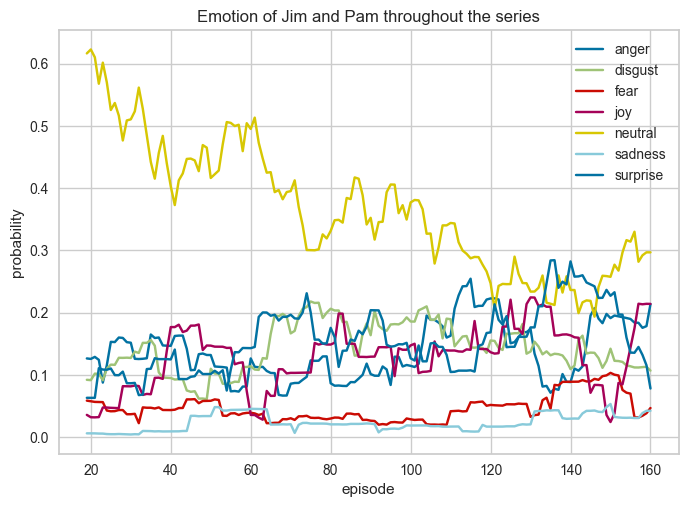

In [84]:
fig = pd.DataFrame(emotion_analysis)[["anger", "disgust", "fear", "joy", "neutral", "sadness", "surprise"]].rolling(20).mean().plot()

fig.set_xlabel("episode")
fig.set_ylabel("probability")
fig.set_title("Emotion of Jim and Pam throughout the series")

# TODO: colors (different for anger and surprise)

- the relationship between Jim an Dwight is becoming less neutral in the course of the show
- note that this is a moving average, e.g. peaks may be flattened here

### Topic Modeling

Key Question: What topics do people talk about in the office?

Approaches:
- LDA (Latent Dirichlet Allocation) with preprocessing through tf*idf scores and CountVectorizer - results for 10 topics not sufficient
- Embeddings with SBert, Dimension reduction with UMAP, Clustering with HDBSCAN
    - Analysis of the results by retrieving top words (by count and tf*idf) per topic - mixed results (roughly 60 topics)
    - iterative topic reduction with cosine similarity (merge most similar topics) - topicx become more general (no value adding results)

New approach: Bertopic
TODO: How does Bertopic work (focus on topic reduction)


In [ ]:
from bertopic import BERTopic

df_unp = preprocess(df_raw)
data_unp = df_unp.line_text.values.tolist()
topic_model = BERTopic()
topics, probs = topic_model.fit_transform(data_unp) 

# show the results (more than 900 topics)
topic_model.visualize_topics()

In [ ]:
# show the results (only first 10 topics)
topic_model.visualize_barchart()

#### Topic reduction

In [ ]:
topic_model.reduce_topics(data_unp, nr_topics=30)

topics = topic_model.topics_
topic_model.visualize_barchart()

In [ ]:
topic_model.visualize_topics()

#### Topics over Time

In [ ]:
import datetime
timestamps = df_unp.season.astype(str).apply(lambda x: datetime.datetime.strptime("000" + x, '%Y')).to_list()
topics_over_time = model.topics_over_time(data_unp, timestamps)

# TODO: select cool topics

model.visualize_topics_over_time(topics_over_time, topics=[0,1,2,3,4,5])

## Network Analysis

Which people in "The Office" interact with each other?

In [40]:
# create a list of important characters in the tv show the office
important_characters = ["Michael", "Dwight", "Jim", "Pam", "Ryan", "Andy", "Kevin", "Angela", "Oscar", "Phyllis", "Stanley", "Meredith", "Toby", "Kelly", "Creed",]

In [41]:
speaker = df.groupby(['season', 'episode', 'scene'])['speaker'].apply(set).reset_index(name='speakers')

character_edges = {}
for c in speaker.iterrows():
    sp = list(c[1]['speakers'])
    seas = c[1]['season']

    for i in range(len(sp)):
        for j in range(i+1, len(sp)):
            character_tuple = (sp[i], sp[j], seas)
            character_tuple_inv = (sp[j], sp[i], seas)
            if character_tuple in character_edges:
                character_edges[character_tuple] += 1
            elif character_tuple_inv in character_edges:
                character_edges[character_tuple_inv] += 1
            else:
                character_edges[character_tuple] = 1

# only keep edges between important characters
character_edges = {k: v for k, v in character_edges.items() if k[0] in important_characters and k[1] in important_characters}

character_edges_grouped = {}

for k, v in character_edges.items():
    character_tuple = (k[0], k[1])

    if character_tuple in character_edges_grouped:
        character_edges_grouped[character_tuple] += v
    else:
        character_edges_grouped[character_tuple] = v

In [42]:
edge_x = []
edge_y = []
edge_w = []

plotly_graph = nx.Graph()
for character_tuple, count in character_edges_grouped.items():
    plotly_graph.add_edge(character_tuple[0], character_tuple[1], weight=count)

pos = nx.spring_layout(plotly_graph, k=100, iterations=600)

for edge in plotly_graph.edges(data=True):
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_x.extend([x0, x1, None])
    edge_y.extend([y0, y1, None])
    edge_w.append(edge[2]['weight'])

total_weights = sum(edge_w)
node_weights = [sum([d['weight'] for (u, v, d) in plotly_graph.edges(data=True) if u == node or v==node]) for node in plotly_graph.nodes()]

fig = go.Figure()

for i in range(len(edge_x)-3):
    fig.add_trace(go.Scatter(x=[edge_x[i], edge_x[i+1]], y=[edge_y[i], edge_y[i+1]],
                                    mode='lines',
                                    line=dict(width=edge_w[int(i/3)]/50, color='#888'),
                                    opacity=1
                                    ))
    i += 3

fig.add_trace(go.Scatter(x=[pos[k][0] for k in pos.keys()], y=[pos[k][1] for k in pos.keys()],
                                    mode='markers',
                                    marker=dict(size=[w/total_weights*300 for w in node_weights], color='rgba(132, 165, 184, 1)', line_width=2, opacity=1),
                                    text=[w for w in edge_w],
                                    hoverinfo='text'
                                    ))

# add labels with the character names to the nodes
for node in plotly_graph.nodes():
    x, y = pos[node]
    fig.add_annotation(x=x, y=y, text=node, showarrow=False, font_size=14)


fig.update_layout(
    title_text="The Office Network Graph",
    title_x=0.5,
    title_font_size=24,
    width=800,
    height=800,
    showlegend=False,
    hovermode='closest',
)

fig.update_xaxes(showticklabels=False, showgrid=False)
fig.update_yaxes(showticklabels=False, showgrid=False)
fig.show()


In [43]:
# plot the above graph with a slider to select the season

import plotly.graph_objects as go
import networkx as nx
from itertools import chain

edge_x = []
edge_y = []
edge_w = []
edge_l = []

plotly_graph = nx.MultiGraph()
for character_tuple, count in character_edges.items():
    plotly_graph.add_edge(character_tuple[0], character_tuple[1], weight=count, label=character_tuple[2])

for edge in plotly_graph.edges(data=True):
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_x.extend([x0, x1, None])
    edge_y.extend([y0, y1, None])
    for i in range(3):
        edge_l.append(edge[2]['label'])
        edge_w.append(edge[2]['weight'])

# node wheigths per season
node_weights = []
for i in range(1, 10):
    node_weights.append([
        sum([d['weight'] for (u, v, d) in plotly_graph.edges(data=True) if (u == node or v == node) and d['label'] == i]) 
        if sum([d['weight'] for (u, v, d) in plotly_graph.edges(data=True) if (u == node or v == node) and d['label'] == i]) != 0 else 0
        for node in plotly_graph.nodes()])

total_weights = sum(edge_w)


fig = go.Figure()

for i in range(len(edge_x)-3):
    fig.add_trace(go.Scatter(x=[edge_x[i], edge_x[i+1]], y=[edge_y[i], edge_y[i+1]],
                                    mode='lines',
                                    line=dict(width=edge_w[int(i/3)]/35, color='#888'),
                                    opacity=1,
                                    text=[edge_w[int(i/3)]],
                                    hoverinfo='text',
                                    ))
    i += 3

for i in range(1,10):
    total_season_weights = sum(node_weights[i-1])
    fig.add_trace(go.Scatter(x=[pos[k][0] for k in pos.keys()], y=[pos[k][1] for k in pos.keys()],
                                    mode='markers',
                                    marker=dict(size=list(np.array(node_weights[i-1])/total_season_weights*500), color='rgba(132, 165, 184, 1)', line_width=2, opacity=1),
                                    text=node_weights[i-1],
                                    hoverinfo='text',
                                    visible=False
                                    ))

# add labels with the character names to the nodes
for node in plotly_graph.nodes():
    x, y = pos[node]
    fig.add_annotation(x=x, y=y, text=node, showarrow=False, font_size=14)


fig.update_layout(
    title_text="The Office Network Graph",
    title_x=0.5,
    title_font_size=24,
    width=800,
    height=800,
    showlegend=False,
    hovermode='closest',
)

fig.update_xaxes(showticklabels=False, showgrid=False)
fig.update_yaxes(showticklabels=False, showgrid=False)

# add a slider to select only some edges based on the season label and adjust the size of the nodes 
steps = []
for season in set(edge_l):
    visible_list = [True if edge_l[i] == season else False for i in range(len(fig.data)-9)]
    visible_list.extend(True if i == season else False for i in set(edge_l))
    
    step = dict(
        method="update",
        args=[{"visible": visible_list},
                {"title": "The Office Network Graph - Season {}".format(season)}],
        label=season
    )
    steps.append(step)


sliders = [dict(
    active=10,
    currentvalue={"prefix": "Season: "},
    pad={"t": 50},
    steps=steps
)]


fig.update_layout(
    sliders=sliders
)

fig.show()

- results....